In [1]:
import qubic
import numpy as np
import matplotlib.pyplot as plt
import scipy
import random
import scipy.special as sci_spe
from scipy.stats import qmc
from time import time
import healpy as hp

In [2]:
h = 4869 # altitude of Qubic
h_atm = 3000 # height of the atmosphere
min_el_qubic = np.radians(30) # minimal elevation of Qubic
c = scipy.constants.c # speed of light
P = 20 # Number of horns along one axis
delta_h = 14e-3 # distance between horns

z_atm = 40000 # (m), typical height that depends on the observation site, on the order of ~10⁴ m
T_ground = 280 # (K), average ground temperature on the observation site

n_air = 1.423e25 # (m^-3), density of air
m_H2O = 2.992e-23 # (g) mass of H2O molecule

In [3]:
dictname = 'pipeline_demo.dict'

thisd = qubic.qubicdict.qubicDict()
thisd.read_from_file(dictname)
thisd['nside'] = 1024
thisd['synthbeam_kmax'] = 3 # We select peaks from the (2 * kmax + 1)**2 = 49 peaks centered on the primary peak
thisd['synthbeam_fraction'] = 0.95 # Peaks will be considered until the sum of their value is 95% the total value

## Molecular absorption coefficient
To get this information, we use the am atmospheric model developped by Paine (Paine, S. 2018, The am atmospheric model).
The absorption coefficient has two origins: the line-by-line absorption which reprensents the spectral lines, and a continuum absorption coming from collisions between molecules, either $H_2O-H_2O$ collisions (self-induced continuum), or collisions between $H_2O$ and the air (air_induced).

So the coefficient $\alpha_b(\nu)$ [$m^2g^{-1}$] is defined by:
$$\alpha_b(\nu) = \frac{1}{m_{H_2O}} \left(k_{lines}(\nu) + n_{H_2O}k_{self}(\nu) + n_{air}k_{air}(\nu)\right)$$
with $m_{H_2O}= 2.992\times 10^{-23} g$ the mass of a $H_2O$ molecule, $k_{lines}$ [$m^2$] the line-by-line absorption coefficient, $k_{self}$ and $k_{air}$ [$m^5$] the self- and air-induced continua, $n_{H_2O}$ and $n_{air}$ [$m^{-3}$] the densities of water vapor and air.

Spectras for the line-by-line absorption-coefficient were produced using .amc files that looks like that:

f 130 GHz  250 GHz  0.005 GHz\
output f  k

layer\
P 500 hPa\
T 280 K\
column h2o_lines 1 mm_pwv

And for the continuum absorption:

f 130 GHz  250 GHz  0.005 GHz\
output f  k

layer\
P 550 hPa\
T 280 K\
h 3000 m\
column h2o_self_continuum 1 mm_pwv

Then we only need to execute a command line like: am file_name.amc > file_name.out

The file 'file_name.out' is created and contains two colomns, one for the frequency, and one for the absorption coefficient. Be careful, results are in cm and not in m.

See the am documentation for more details: https://zenodo.org/records/8161272

Let's first consider the line-by-line absorption coefficient and its dependance on temperature and pressure.

In [4]:
frequencies = []
_550hPa_280K_1mm = []

with open('absorption_coefficient/h2o_lines_550hPa_280K_1mm.out', 'r') as file:
    for line in file:
        parts = line.split() # Split the line into two parts based on whitespace
        frequencies.append(float(parts[0]))
        _550hPa_280K_1mm.append(float(parts[1]))

name_dict = {} 
name_dict['_500hPa_280K_1mm'] = []
name_dict['_600hPa_280K_1mm'] = []
name_dict['_550hPa_260K_1mm'] = []
name_dict['_550hPa_300K_1mm'] = []

for name, list in name_dict.items():
    with open('absorption_coefficient/h2o_lines'+name+'.out', 'r') as file:
        for line in file:
            parts = line.split() # Split the line into two parts based on whitespace
            list.append(float(parts[1]))

name_dict['_550hPa_280K_1mm'] = _550hPa_280K_1mm

for name, list in name_dict.items():
    name_dict[name] = np.array(list)*(1e-4)

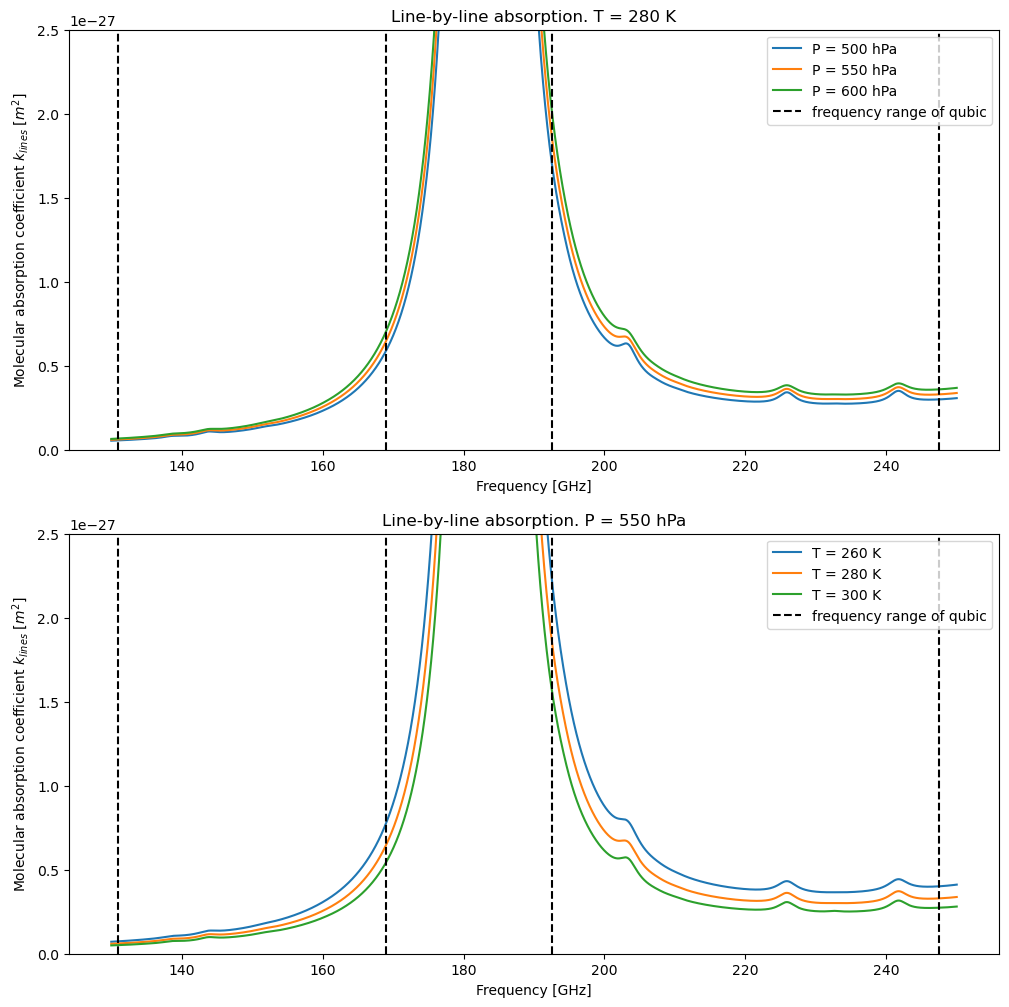

In [5]:
y_max = 2.5e-27

plt.figure(figsize=(12,12))

plt.subplot(2,1,1)
plt.plot(frequencies, name_dict['_500hPa_280K_1mm'], label='P = 500 hPa')
plt.plot(frequencies, name_dict['_550hPa_280K_1mm'], label='P = 550 hPa')
plt.plot(frequencies, name_dict['_600hPa_280K_1mm'], label='P = 600 hPa')

plt.ylim(0, y_max)
plt.vlines(131, 0, y_max, 'black', 'dashed', label='frequency range of qubic')
plt.vlines(169, 0, y_max, 'black', 'dashed')
plt.vlines(192.5, 0, y_max, 'black', 'dashed')
plt.vlines(247.5, 0, y_max, 'black', 'dashed')
plt.xlabel('Frequency [GHz]')
plt.ylabel(r'Molecular absorption coefficient $k_{lines}$ [$m^2$]')
plt.title('Line-by-line absorption. T = 280 K')
plt.legend()


plt.subplot(2,1,2)
plt.plot(frequencies, name_dict['_550hPa_260K_1mm'], label='T = 260 K')
plt.plot(frequencies, name_dict['_550hPa_280K_1mm'], label='T = 280 K')
plt.plot(frequencies, name_dict['_550hPa_300K_1mm'], label='T = 300 K')

plt.ylim(0, y_max)
plt.vlines(131, 0, y_max, 'black', 'dashed', label='frequency range of qubic')
plt.vlines(169, 0, y_max, 'black', 'dashed')
plt.vlines(192.5, 0, y_max, 'black', 'dashed')
plt.vlines(247.5, 0, y_max, 'black', 'dashed')
plt.xlabel('Frequency [GHz]')
plt.ylabel(r'Molecular absorption coefficient $k_{lines}$ [$m^2$]')
plt.title('Line-by-line absorption. P = 550 hPa')
plt.legend()

plt.show()

Now, lets consider the self- and air-induces continua. The self-induce absorption coefficient is much lower than the air-induced absorption coefficient, so we will ignore it for the rest of the notebook. Note that the self-induced continuum depends on $n_{H_2O}$ (or equivalently $\rho_{H_2O}$), so it would be harder to take it into account as we are interested in spatail variations of the water vapor density.

In [6]:
h2o_self = []
h2o_air = []

with open('absorption_coefficient/h2o_self_continuum.out', 'r') as file:
    for line in file:
        parts = line.split() # Split the line into two parts based on whitespace
        h2o_self.append(float(parts[1]))

with open('absorption_coefficient/h2o_air_continuum.out', 'r') as file:
    for line in file:
        parts = line.split() # Split the line into two parts based on whitespace
        h2o_air.append(float(parts[1]))

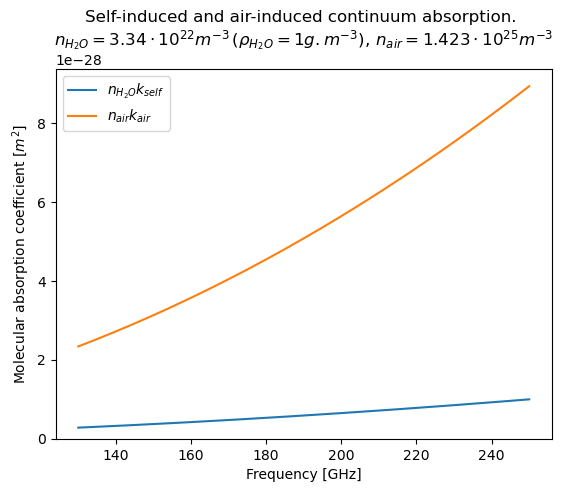

In [9]:
plt.figure()
plt.plot(frequencies, np.array(h2o_self)*(1e-10*3.34*1e22), label=r'$n_{H_2O}k_{self}$')
plt.plot(frequencies, np.array(h2o_air)*(1e-10*n_air), label=r'$n_{air}k_{air}$')

plt.ylim(0)
plt.xlabel('Frequency [GHz]')
plt.ylabel(r'Molecular absorption coefficient [$m^2$]')
plt.title('Self-induced and air-induced continuum absorption. \n' 
          r'$n_{H_2O} = 3.34 \cdot{} 10^{22} m^{-3}\, (\rho_{H_2O} = 1 g.m^{-3}),\, n_{air} = 1.423\cdot{}10^{25} m^{-3}$')
plt.legend()
plt.show()
#plt.savefig('continuum_absorption.pdf')
#plt.close()

We can now plot the parameter $\alpha_b(\nu)$ [$m^2g^{-1}$].

In [10]:
absorption_coeff_mass = (name_dict['_550hPa_280K_1mm'] + np.array(h2o_air)*(1e-10*n_air)) / m_H2O

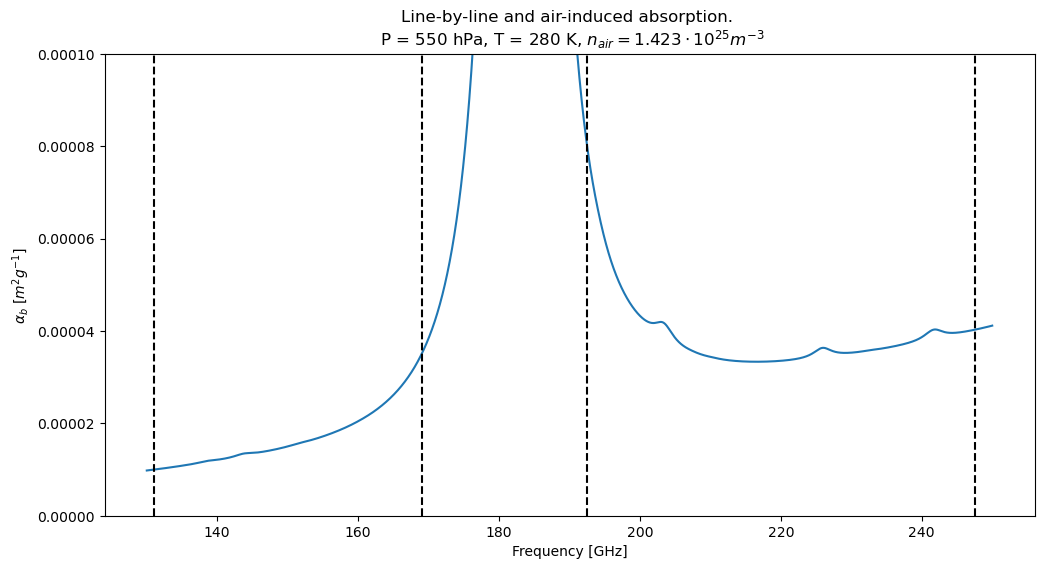

In [13]:
plt.figure(figsize=(12,6))

plt.plot(frequencies, absorption_coeff_mass)

y_max = 1e-4
plt.ylim(0, y_max)
plt.vlines(131, 0, y_max, 'black', 'dashed', label='frequency range of qubic')
plt.vlines(169, 0, y_max, 'black', 'dashed')
plt.vlines(192.5, 0, y_max, 'black', 'dashed')
plt.vlines(247.5, 0, y_max, 'black', 'dashed')
plt.xlabel('Frequency [GHz]')
plt.ylabel(r'$\alpha_b$ [$m^2g^{-1}$]')
plt.title('Line-by-line and air-induced absorption. \n P = 550 hPa, T = 280 K, $n_{air} = 1.423\cdot{}10^{25} m^{-3}$')
plt.show()
#plt.savefig('frequency_coefficient.pdf')
#plt.close()

Let's define a function that computes the integral over each frequency sub-band of the parameter $\alpha_b(\nu)$.

It is not clear how we should intergate the absorption coeffcient. This function should be changed.

In [15]:
#It is not clear how we should intergate the absorption coeffcient. This function should be changed.

def absorption_coeff_integrated(band, Nfreq, relative_bandwidth):
    '''
    Returns the integral of the coefficient alpha_b over each freqency sub-band.
    Band is 150 or 220 (GHz).
    The result is a list of length Nfreq.
    '''
    freq_max = np.max(frequencies)
    freq_min = np.min(frequencies)
    freq_step = (freq_max - freq_min) / (len(frequencies) - 1)
    
    _, nus_edge, _, _, _, Nbbands = qubic.compute_freq(band, Nfreq, relative_bandwidth)

    nus_edge_index = (nus_edge - freq_min) / freq_step
    absorption_coeff = []
    
    for i in range(Nbbands):
        index_inf = int(nus_edge_index[i])
        index_sup = int(nus_edge_index[i+1])
        absorption_coeff.append(np.sum(absorption_coeff_mass[index_inf:index_sup]) * 
                                (frequencies[index_sup] - frequencies[index_inf])*1e9 / (index_sup - index_inf))
        
    return absorption_coeff

In [16]:
absorption_coeff_integrated(150, 10, thisd['filter_relative_bandwidth'])

[34629.849661280125,
 38266.449216861445,
 42454.694738820435,
 47517.34400434486,
 51751.68119926463,
 58042.927076236956,
 65844.25460182146,
 77019.49270462873,
 93786.39734879702,
 122846.76405909087]

## Mean water vapor density

In [17]:
def water_vapor_density(height, rho_0=1, h0=1000):
    '''
    Water vapor density as a function of geopotential height in m
    rho_0: Reference mean density of water vapor in g/m³
    h0: The half height for water vapor in m
    '''
    return rho_0 * np.exp(-np.log(2) * (height - 5190) / h0)

water_vapor_0 = water_vapor_density(h, 1, 1000)

## Temperature

In [18]:
def atm_temp(height):
    '''
    Temperature of the atmosphere as a function of geopotential height in m
    Returns temperature in Kelvin
    '''
    return T_ground * (1 - (height-h)/z_atm)

## Correlation function

In [19]:
def kolmogorov_correlation(r, r0=300):
    '''
    Correlation function of water vapor as a function of distance r (Kolmogorov model).
    Due to the modified Bessel function, this function is very costly to compute.
    '''
    return np.where(r==0, 1, 2**(2/3)/sci_spe.gamma(1/3)*(r/r0)**(1/3)*sci_spe.kv(1/3, r/r0))

/var/folders/h5/wmsn3xqd3hnf0f7b3xnqnq3w0000gn/T/ipykernel_32413/1372315812.py:6: RuntimeWarning: invalid value encountered in multiply
  return np.where(r==0, 1, 2**(2/3)/sci_spe.gamma(1/3)*(r/r0)**(1/3)*sci_spe.kv(1/3, r/r0))


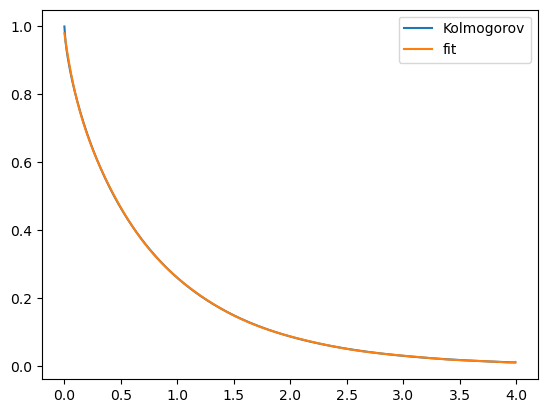

In [20]:
r = np.arange(0, 4, 0.01)
corr = kolmogorov_correlation(r, r0=1)
fit_parameters = np.polyfit(r, corr, 12)
fit_list = np.polyval(fit_parameters, r)
plt.plot(r, corr, label='Kolmogorov')
plt.plot(r, fit_list, label='fit')
plt.legend()
plt.show()

In [21]:
def correlation_function(r, r0=300):
    '''
    Polynomial approximation of Kolmogorov's correlation. Computation is much faster.
    For distances greater than the fit, the value is set to 0 to avoid the divergence of the polynomial fit.
    '''
    return np.where(r>4*r0, 0, np.polyval(fit_parameters, r/r0))

## Points for quasi Monte Carlo integration
We will here generate a sample of Quasi-Monte Carlo points that will be used for the computation.

In [22]:
def get_detector_integration_operator(self):
    """
    Integrate flux density in detector solid angles and take into account
    the secondary beam transmission.
    """
    position = self.detector.center
    area = self.detector.area
    secondary_beam = self.secondary_beam
    theta = np.arctan2(
        np.sqrt(np.sum(position[..., :2] ** 2, axis=-1)), position[..., 2])
    phi = np.arctan2(position[..., 1], position[..., 0])
    sr_det = -area / position[..., 2] ** 2 * np.cos(theta) ** 3
    sr_beam = secondary_beam.solid_angle
    sec = secondary_beam(theta, phi)
    return sr_det / sr_beam * sec

In [23]:
def qubic_beam(i, freq):
    '''
    Returns the coordinates and value of the peaks of the detector i at frequency freq
    '''
    thisd['filter_nu'] = freq
    thisq = qubic.QubicInstrument(thisd)
    s = qubic.QubicScene(thisd)
    integration = get_detector_integration_operator(thisq)[i]
    theta, phi, val = thisq._peak_angles(s, thisd['filter_nu'], 
                                     np.reshape(thisq.detector.center[i,:], (1,3)), 
                                     thisq.synthbeam, thisq.horn, thisq.primary_beam)
    return np.array([theta[0], phi[0], val[0]/np.sum(val[0])*integration])

In [24]:
# Scales a sample to go from a 6D hypercube to two cones, one for each detector
def scaling_function(arr, z_max, freq, r0):
    '''
    arr is a 6D hypercube. Here we shape it into two cones, one for each detector. 
    Each cone is representing only one peak, we will need to rotates thoses cones afterwards.
    '''
    zi = arr[:,2]*r0-r0/2 + arr[:,5]*z_max
    zj = -(arr[:,2]*r0-r0/2) + arr[:,5]*z_max

    zi = np.where(zi<0, -zi, zi)
    zi = np.where(zi>z_max, 2*z_max-zi, zi)
    zj = np.where(zj<0, -zj, zj)
    zj = np.where(zj>z_max, 2*z_max-zj, zj)
 
    radius = c / ((P-1) * delta_h * freq) / np.sqrt(2/np.log(2))

    cylindrical = np.empty(np.shape(arr))

    cylindrical[:] = np.array([arr[:,0]*2*np.pi, radius*zi * np.sqrt(arr[:,1]), zi, 
                            arr[:,3]*2*np.pi, radius*zj * np.sqrt(arr[:,4]), zj]).T

    scaled_arr = cylindrical.copy()
    scaled_arr[:,0] = cylindrical[:,1] * np.cos(cylindrical[:,0])
    scaled_arr[:,1] = cylindrical[:,1] * np.sin(cylindrical[:,0])
    scaled_arr[:,3] = cylindrical[:,4] * np.cos(cylindrical[:,3])
    scaled_arr[:,4] = cylindrical[:,4] * np.sin(cylindrical[:,3])

    return scaled_arr


In [25]:
# Function to generate integration points within variable-dependent bounds
def monte_carlo_points(freq, n, r0=300, h=h, h_atm=h_atm, min_el_qubic=min_el_qubic):
    '''
    Returns a sample of points that are in the two beams (so in 6 dimensions). 
    This is done using a Sobol' sequence to have a uniform distribution in the 6D space.
    The number of points generated is 2**n
    '''

    # Generates the points in 6D space
    sampler = qmc.Sobol(d=6, scramble=True)#, optimization='random-cd')
    points = sampler.random_base2(m=n)

    z_max = h_atm / np.sin(min_el_qubic)

    # Scales the points aproximatly in the beams.
    # We want the distance between zi and zj to be less than r0.
    # For (xi, yi), we scale the points in a circle of radius growing with zi.
    scaled_points = scaling_function(points, z_max, freq, r0)

    return np.split(scaled_points, 2, axis=1)

In [39]:
%timeit monte_carlo_points(150e9, 15, r0=300)

6.68 ms ± 373 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
def rotated_points(points, list_peaks):
    '''
    Rotates the points of the peak of each detector 
    '''
    theta, phi, _ = list_peaks

    c_the = np.cos(theta); s_the = np.sin(theta)
    c_phi = np.cos(phi); s_phi = np.sin(phi)

    L1 = np.array([c_phi**2*(1-c_the)+c_the, c_phi*s_phi*(1-c_the), -s_phi*s_the])
    L2 = np.array([c_phi*s_phi*(1-c_the), s_phi**2*(1-c_the)+c_the, c_phi*s_the])
    L3 = np.array([s_phi*s_the, -c_phi*s_the, c_the])

    R_k = np.transpose(np.array([L1, L2, L3]), axes=(2,0,1))

    return points @ R_k


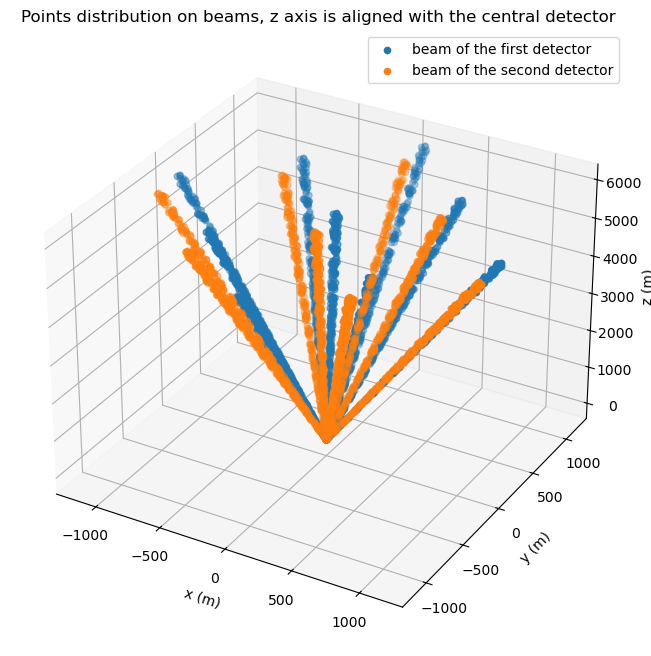

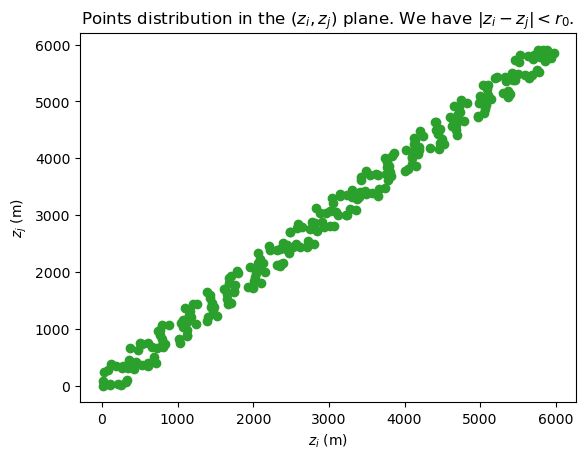

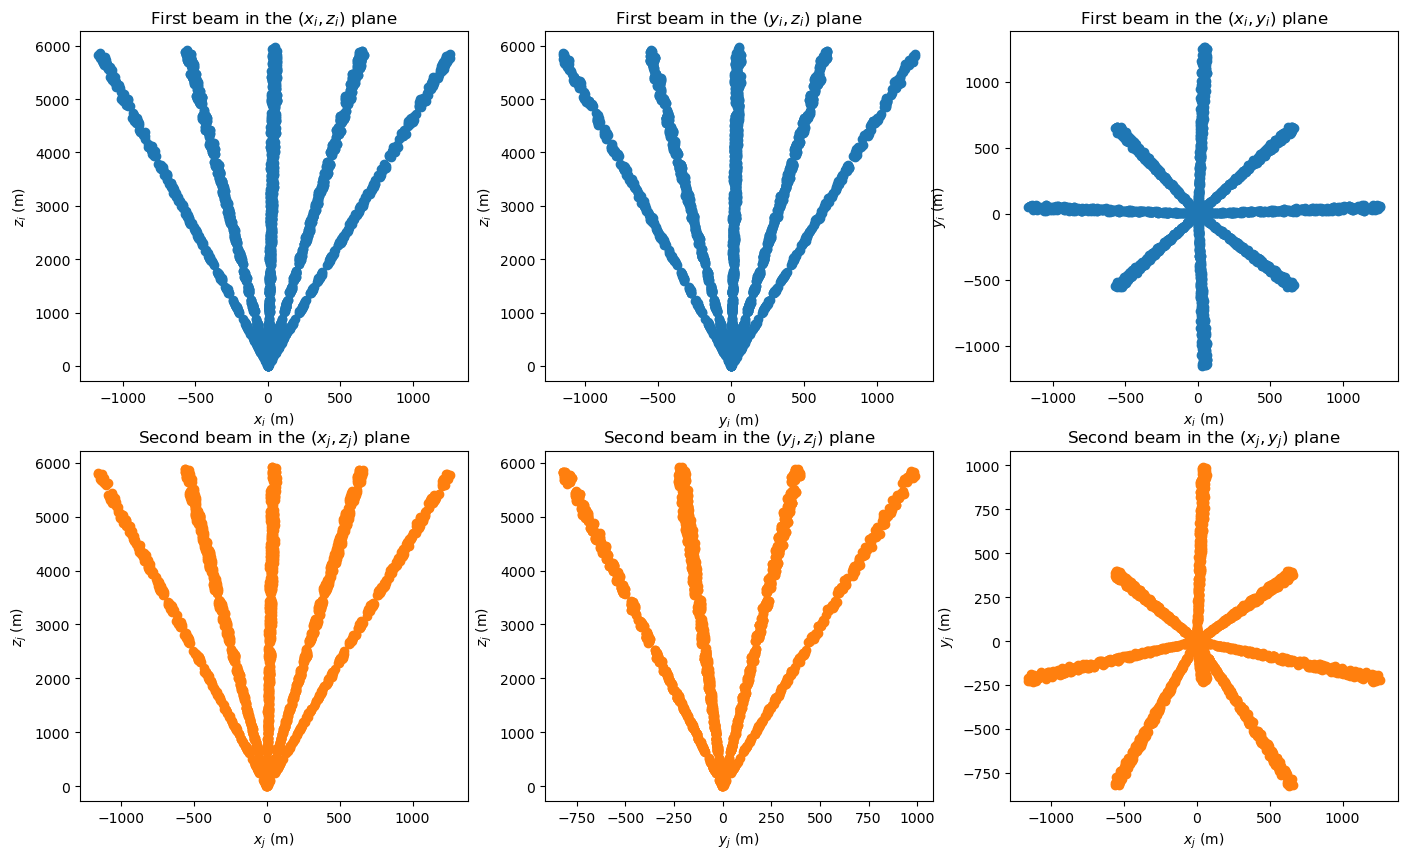

In [123]:
list_peaks_i = qubic_beam(231, 150e9)
list_peaks_j = qubic_beam(0, 150e9)

n = 8

points = monte_carlo_points(150e9, n, r0=300)
points_i = rotated_points(points[0], list_peaks_i)
points_j = rotated_points(points[1], list_peaks_j)

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(points_i[..., 0], points_i[..., 1], points_i[..., 2], label='beam of the first detector', c='tab:blue')
scatter = ax.scatter(points_j[..., 0], points_j[..., 1], points_j[..., 2], label='beam of the second detector', c='tab:orange')

# Set labels
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')
ax.set_title('Points distribution on beams, z axis is aligned with the central detector')
limit = np.max((np.max(np.abs(points_i[..., 0])), np.max(np.abs(points_i[..., 1])), 
                np.max(np.abs(points_j[..., 0])), np.max(np.abs(points_j[..., 1]))))
ax.set_xlim(-limit,limit)
ax.set_ylim(-limit,limit)
plt.legend()
plt.show()
#plt.savefig('point_distribution.pdf')
#plt.close()


plt.scatter(points_i[0, :, 2], points_j[0, :, 2], c='tab:green')
plt.xlabel(r'$z_i$'+' (m)')
plt.ylabel(r'$z_j$'+' (m)')
plt.title('Points distribution in the '+r'$(z_i, z_j)$'+' plane. We have '+r'$\vert z_i-z_j\vert < r_0.$')
plt.show()

plt.figure(figsize = (17,10))

plt.subplot(2,3,1)
plt.scatter(points_i[..., 0], points_i[..., 2], c='tab:blue')
plt.xlabel(r'$x_i$'+' (m)')
plt.ylabel(r'$z_i$'+' (m)')
plt.title('First beam in the '+r'$(x_i, z_i)$'+' plane')

plt.subplot(2,3,2)
plt.scatter(points_i[..., 1], points_i[..., 2], c='tab:blue')
plt.xlabel(r'$y_i$'+' (m)')
plt.ylabel(r'$z_i$'+' (m)')
plt.title('First beam in the '+r'$(y_i, z_i)$'+' plane')

plt.subplot(2,3,3)
plt.scatter(points_i[..., 0], points_i[..., 1], c='tab:blue')
plt.xlabel(r'$x_i$'+' (m)')
plt.ylabel(r'$y_i$'+' (m)')
plt.title('First beam in the '+r'$(x_i, y_i)$'+' plane')

plt.subplot(2,3,4)
plt.scatter(points_j[..., 0], points_j[..., 2], c='tab:orange')
plt.xlabel(r'$x_j$'+' (m)')
plt.ylabel(r'$z_j$'+' (m)')
plt.title('Second beam in the '+r'$(x_j, z_j)$'+' plane')

plt.subplot(2,3,5)
plt.scatter(points_j[..., 1], points_j[..., 2], c='tab:orange')
plt.xlabel(r'$y_j$'+' (m)')
plt.ylabel(r'$z_j$'+' (m)')
plt.title('Second beam in the '+r'$(y_j, z_j)$'+' plane')

plt.subplot(2,3,6)
plt.scatter(points_j[..., 0], points_j[..., 1], c='tab:orange')
plt.xlabel(r'$x_j$'+' (m)')
plt.ylabel(r'$y_j$'+' (m)')
plt.title('Second beam in the '+r'$(x_j, y_j)$'+' plane')
plt.show()


## Computation of the correlation between two detectors

In [28]:
def xyz_to_NWZ(x, y, z, az, el):
    '''
    Transform the coordinates in the frame of the detector to the coordinates system (North, West, Zenith)
    '''
    N = x*np.sin(az) - y*np.sin(el)*np.cos(az) + z*np.cos(el)*np.cos(az)
    W = x*np.cos(az) + y*np.sin(el)*np.sin(az) - z*np.cos(el)*np.sin(az)
    Z = y*np.cos(el) + z*np.sin(el)
    return N, W, Z

In [29]:
def qubic_beam_value(x, y, z, theta, phi, val, freq):
    '''
    Beam profile, integral over x,y normalized.
    '''
    coef = np.pi * delta_h * freq / c
    X = coef * (x/z - theta * np.sin(phi))
    Y = coef * (y/z + theta * np.cos(phi))
    return val * (np.sinc(P * X / np.pi) * np.sinc(P * Y / np.pi))**2 / (c * z / (P*delta_h * freq))**2

0.004423291287265031


(0.0, 0.02047305286185774)

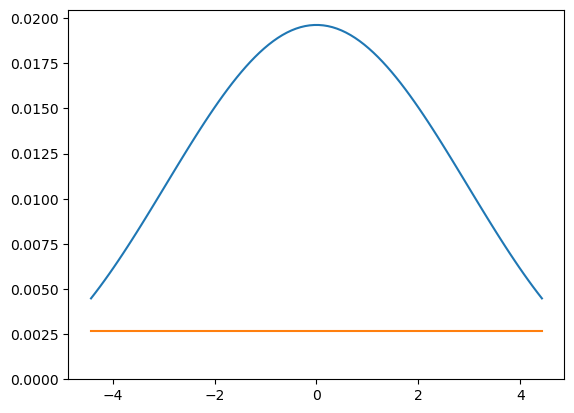

In [30]:
z = 1000
freq = 150e9
angle = c / ((P-1) * delta_h * freq) / np.sqrt(2/np.log(2))
print(angle)
x = np.linspace(-angle*z, angle*z, 100)
plt.plot(x, qubic_beam_value(x, 0, z, 0, 0, 1, 150e9))
plt.plot(x, [np.max(qubic_beam_value(x, 0, z, 0, 0, 1, 150e9))/np.exp(2)]*len(x))
plt.ylim(0)
#plt.plot(x, np.exp(-2*x**2/(angle*z)**2)/52)

Checking that the integral over x and y is the same, for every z, frequency, or detector.

In [21]:
freq = 150e9
theta, phi, val = qubic_beam(317, freq)
angle = c / (freq * (P-1) * delta_h)
for z in [100, 200, 300, 2000]:
    int = 0
    for i in range (len(theta)):
        X = theta[i] * np.sin(phi[i]) * z
        Y = -theta[i] * np.cos(phi[i]) * z
        int += scipy.integrate.dblquad(lambda x,y: qubic_beam_value(x, y, z, theta[i], phi[i], val[i], freq), Y-2*angle*z, Y+2*angle*z, X-2*angle*z, X+2*angle*z)[0]
    print(int)


0.9027193458795013
0.9027193458795013
0.9027193458795025
0.9027193458795018


In [31]:
def integrand_one_beam(coords, list_peaks, el, freq):
    '''

    '''
    x = coords[...,0]; y = coords[...,1]; z = coords[...,2]
    theta, phi, val = list_peaks

    # Geopotential height
    height = h + z*np.sin(el) + y*np.cos(el)

    # To compute the integral we need to weight by the surface at each height zi or zj 
    # to take into account that the density of points changes with height
    radius = c / ((P-1) * delta_h * freq) / np.sqrt(2/np.log(2))
    
    return water_vapor_density(height) * atm_temp(height) * radius**2 * z**2 * np.pi * qubic_beam_value(x, y, z, theta[:,None], phi[:,None], val[:,None], freq)


In [32]:
def integrand_correlations_qubic(coords_i, coords_j, beam_i, beam_j, ti, az_ti, el_ti, tj, az_tj, el_tj, W, phi_W, freq, r0=300):
    '''
    Integrand for the correlation function.
    coords is the list of the 6 dimensions coordinates of a pair of points.
    peak_i is the coordinate and value of the peak we are considering.
    ti and tj are the moment of observation for detector i and j
    az_ti and el_tj is the azimuth and the elevation of the central detector at time ti
    W the norm of the speed of the wind
    phi_W the azimuth of the wind
    freq the frequence
    '''
    xi = coords_i[...,0]; yi = coords_i[...,1]; zi = coords_i[...,2]
    xj = coords_j[...,0]; yj = coords_j[...,1]; zj = coords_j[...,2]

    # Distance between the two points in the sky taking into account the wind
    Ni, Wi, Zi = xyz_to_NWZ(xi, yi, zi, az_ti, el_ti)
    Nj, Wj, Zj = xyz_to_NWZ(xj, yj, zj, az_tj, el_tj)
    N_wind, W_wind = np.cos(phi_W)*W*(tj-ti), -np.sin(phi_W)*W*(tj-ti) # Spatial shift due to the wind
    
    r_ij = np.sqrt((Nj[None, ...]-Ni[:, None, ...]-N_wind)**2 + (Wj[None, ...]-Wi[:, None, ...]-W_wind)**2 + (Nj[None, ...]-Ni[:, None, ...])**2)
    
    return correlation_function(r_ij, r0=r0) * beam_i[:, None, ...] * beam_j[None, ...]
    

In [33]:
def atm_correlations_qubic(points, list_peaks_i, list_peaks_j, ti, az_ti, el_ti, tj, az_tj, el_tj, W, phi_W, freq, r0=300):
    
    rot_points_i = rotated_points(points[0], list_peaks_i)
    rot_points_j = rotated_points(points[1], list_peaks_j)

    beam_i = integrand_one_beam(rot_points_i, list_peaks_i, el_ti, freq)
    beam_j = integrand_one_beam(rot_points_j, list_peaks_j, el_tj, freq)

    int = np.sum(integrand_correlations_qubic(rot_points_i, rot_points_j, beam_i, beam_j,
                                ti, az_ti, el_ti, tj, az_tj, el_tj, W, phi_W, freq, r0=r0))

    # Surface in the (zi,zj) plane
    z_max = h_atm / np.sin(min_el_qubic)
    Sz = z_max**2 - (z_max-r0)**2

    if freq==150e9:
        molecular_absorption_coeff = absorption_coeff_integrated(150, 1, thisd['filter_relative_bandwidth'])[0]
    elif freq==220e9:
        molecular_absorption_coeff = absorption_coeff_integrated(220, 1, thisd['filter_relative_bandwidth'])[0]
    else:
        raise Exception('freq should be 150e9 or 220e9')

    return molecular_absorption_coeff**2 * int / np.shape(points)[1] * Sz
    

## Time of execution

In [121]:
freq = 150e9
list_peaks_i = qubic_beam(231, freq) #np.array([[0], [0], [1]]) #qubic_beam(231, freq)
list_peaks_j = qubic_beam(0, freq) #np.array([[np.radians(10)], [0], [1]]) #qubic_beam(231, freq)
points = monte_carlo_points(freq, 9)
%timeit atm_correlations_qubic(points, list_peaks_i, list_peaks_j, 0, 0, np.radians(45), 0, 0, np.radians(45), 0, 0, freq)

4.55 ms ± 222 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
points = monte_carlo_points(freq, 9)
list_peaks_i = qubic_beam(231, freq)
list_peaks_j = qubic_beam(0, freq)
atm_correlations_qubic(points, list_peaks_i, list_peaks_j, 0, 0, np.radians(45), 0, 0, np.radians(45), 0, 0, freq)

1864044143628429.2

## Temperature of one detector

In [167]:
def mean_temperature(height_atm, list_peaks, az, el, freq):
    points = monte_carlo_points(freq, 12, h_atm=height_atm)
    rot_points = rotated_points(points[0], list_peaks)
    beam = integrand_one_beam(rot_points, list_peaks, el, freq)
    z_max = height_atm / np.sin(min_el_qubic)

    if freq==150e9:
        molecular_absorption_coeff = absorption_coeff_integrated(150, 1, thisd['filter_relative_bandwidth'])[0] / 150e9
    elif freq==220e9:
        molecular_absorption_coeff = absorption_coeff_integrated(220, 1, thisd['filter_relative_bandwidth'])[0] / 220e9
    else:
        raise Exception('freq should be 150e9 or 220e9')

    return molecular_absorption_coeff * np.sum(beam) / np.shape(points)[1] * z_max

In [168]:
list_peaks = qubic_beam(231, freq)
temp_list = []
height_list = np.arange(0, 10100, 100)
for height in height_list:
    temp_list.append(mean_temperature(height, list_peaks, 0, min_el_qubic, 150e9))

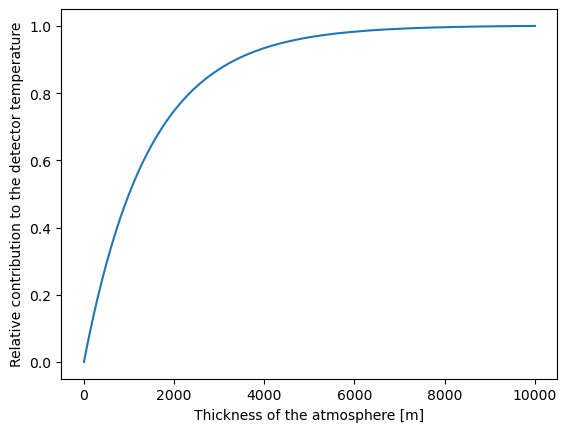

In [171]:
plt.figure()
plt.plot(height_list, temp_list/temp_list[-1])
plt.xlabel('Thickness of the atmosphere [m]')
plt.ylabel('Relative contribution to the detector temperature')
plt.show()
#plt.savefig('atmosphere_thickness.pdf')
#plt.close()

In [116]:
list_peaks = qubic_beam(231, freq)
temp_list = []
elevation_list = np.arange(30, 91, 2)
for el in elevation_list:
    temp_list.append(mean_temperature(h_atm, list_peaks, 0, np.radians(el), 150e9))

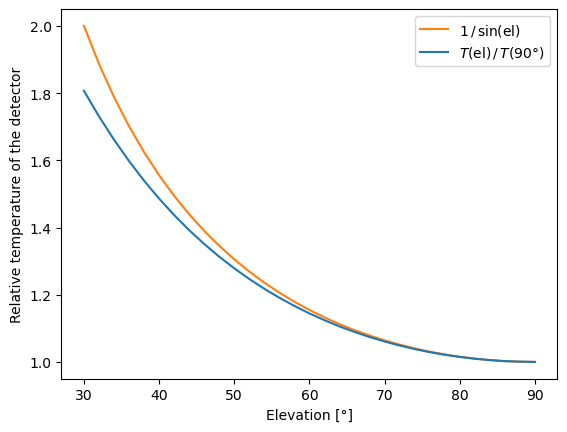

In [119]:
plt.figure()
plt.plot(elevation_list, 1/np.sin(np.radians(elevation_list)), c='tab:orange', label=r'$1 \,/\, \sin(\text{el})$')
plt.plot(elevation_list, temp_list/temp_list[-1], c='tab:blue', label=r'$T(\text{el}) \,/\, T(90°)$')
plt.xlabel('Elevation [°]')
plt.ylabel('Relative temperature of the detector')
plt.legend()
plt.show()
#plt.savefig('temperature_elevation.pdf')
#plt.close()

## Convergence

[1.41498212 1.10909156 0.93301303 1.05070234 0.97936574 1.00125399
 1.00415089 1.00100205 1.        ]
8677228652629381.0
[1.15713915 0.85809543 0.95086889 0.96164729 0.9692367  0.98899224
 0.99586318 0.99373307 1.        ]
8685058672770632.0
[1.09144629 1.17453229 1.07050881 1.0939238  1.01755319 0.98824701
 1.01032843 1.00073275 1.        ]
8662903584138127.0
[1.01405418 0.85366079 0.91581097 1.01550981 1.01450121 0.99975142
 1.00148957 1.00176061 1.        ]
8666272785916895.0
[1.39920554 1.02204094 0.9535705  0.97439491 1.06054625 0.99286884
 0.99459567 0.99751879 1.        ]
8676348013889304.0
[1.26378916 1.06595872 1.00629801 1.05968694 1.00829287 1.01666288
 1.01166855 0.99988997 1.        ]
8669935303436873.0
[1.12142973 1.34650718 1.16853469 1.00561514 0.9903083  0.98316971
 1.01562712 1.00150267 1.        ]
8662625180137626.0
[1.33988004 1.1384201  0.89506234 0.97749601 0.96690166 1.00637929
 1.0170996  1.0033525  1.        ]
8672680202711115.0
[1.22713561 0.92373844 0.9547895

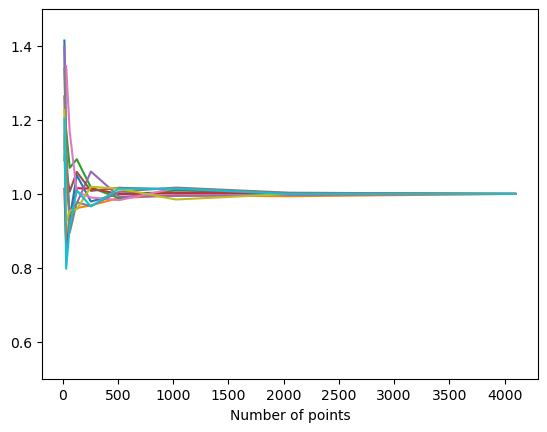

In [31]:
n_list = np.arange(4, 13)
freq = 150e9
list_peaks_i = qubic_beam(231, freq) #np.array([[0], [0], [1]]) #qubic_beam(231, freq)
list_peaks_j = qubic_beam(231, freq) #np.array([[np.radians(10)], [0], [1]]) #qubic_beam(231, freq)
for i in range(10):
    corr=[]
    for n in n_list:
        points = monte_carlo_points(freq, n)
        corr.append(atm_correlations_qubic(points, list_peaks_i, list_peaks_j, 0, 0, np.radians(45), 0, 0, np.radians(45), 0, 0, freq))
    plt.plot(2**n_list, corr/corr[-1])
    print(corr/corr[-1])
    print(corr[-1])
plt.xlabel('Number of points')
plt.ylim(0.5, 1.5)
plt.show()

Only $2^9=512$ points are needed to get a convergence up to a few percent.

## Correlations between detectors

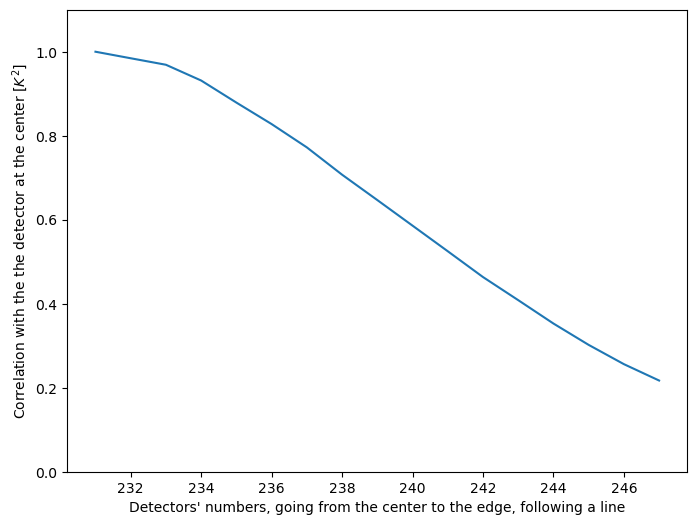

In [32]:
corr=[]
freq = 150e9
points = monte_carlo_points(freq, 9)
list_peaks_i = qubic_beam(231, freq)
det_list = np.arange(231, 248, 1)
for det in det_list:
    list_peaks_j = qubic_beam(det, freq)
    corr.append(atm_correlations_qubic(points, list_peaks_i, list_peaks_j, 0, 0, np.radians(45), 0, 0, np.radians(45), 0, 0, 150e9))
plt.figure(figsize = (8,6))
plt.plot(det_list, corr/corr[0])
plt.xlabel('Detectors\' numbers, going from the center to the edge, following a line')
plt.ylabel('Correlation with the the detector at the center '+r'$[K^2]$')
plt.ylim(0, np.max(corr/corr[0])*1.1)
plt.show()

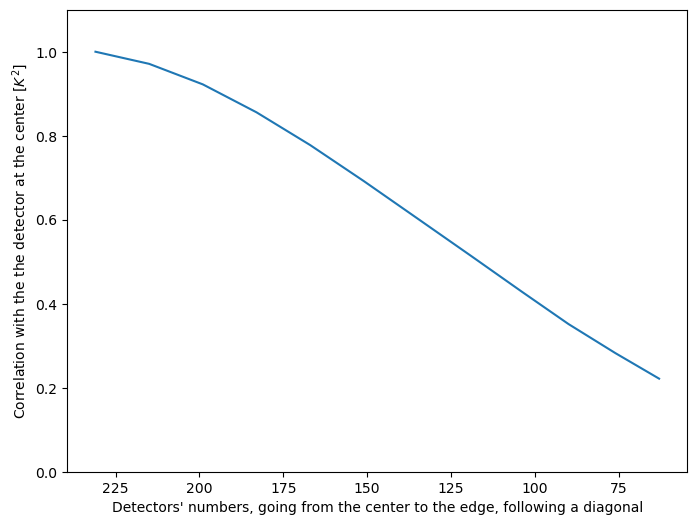

In [57]:
corr=[]
freq = 150e9
points = monte_carlo_points(freq, 9)
list_peaks_i = qubic_beam(231, freq)
det_list = [231, 215, 199, 183, 167, 151, 135, 119, 104, 90, 76, 63]
for det in det_list:
    list_peaks_j = qubic_beam(det, freq)
    corr.append(atm_correlations_qubic(points, list_peaks_i, list_peaks_j, 0, 0, np.radians(45), 0, 0, np.radians(45), 0, 0, 150e9))
plt.figure(figsize = (8,6))
plt.plot(det_list, corr/corr[0])
plt.xlabel('Detectors\' numbers, going from the center to the edge, following a diagonal')
plt.ylabel('Correlation with the the detector at the center '+r'$[K^2]$')
plt.gca().invert_xaxis()
plt.ylim(0, np.max(corr/corr[0])*1.1)
plt.show()

We observe that the detectors are higly correlated. 
We can understand this easily: after ~8° of rotation, all the peaks of the second beam will have rotate and met an other peak of the first beam. So we expect the same result. 
In between, ~4°, the peaks ar still highly correlated. Indeed the distance in the sky at 4° for z = 2 km is 140 m, less than r0 ~ 300m.
To confirm this hypothesis, we can redo the calculation of the first graph with r0 = 15 m. We also change the frequency to 220 GHz, that way the peaks are nearer and we can observe the point were all peaks meet again.

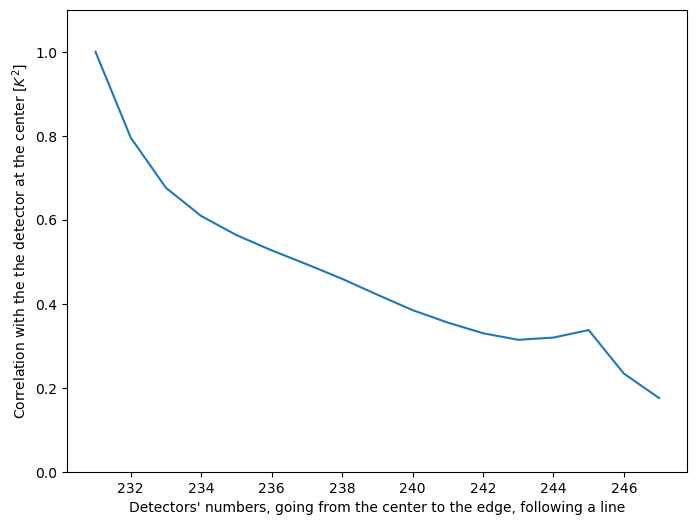

In [58]:
corr=[]
freq = 220e9
r0 = 10
points = monte_carlo_points(freq, 9, r0=r0)
list_peaks_i = qubic_beam(231, freq)
det_list = np.arange(231, 248, 1)
for det in det_list:
    list_peaks_j = qubic_beam(det, freq)
    corr.append(atm_correlations_qubic(points, list_peaks_i, list_peaks_j, 0, 0, np.radians(45), 0, 0, np.radians(45), 0, 0, 150e9, r0=r0))
plt.figure(figsize = (8,6))
plt.plot(det_list, corr/corr[0])
plt.xlabel('Detectors\' numbers, going from the center to the edge, following a line')
plt.ylabel('Correlation with the the detector at the center '+r'$[K^2]$')
plt.ylim(0, np.max(corr/corr[0])*1.1)
plt.show()

## Scanning

In [124]:
W = 0                        # Speed of the wind (m s^-1)
phi_W = 0                    # Azimuth of the wind (rad)
delta_az = np.radians(40)     # Angular size of the scan in the azimuth direction (rad)
ss = np.radians(5)           # Scanning speed (rad s^-1)
f_scan = ss/(2*delta_az)      # Scan frequency (Hz)
freq = 150e9
r0 = 300
list_peaks = qubic_beam(231, freq)

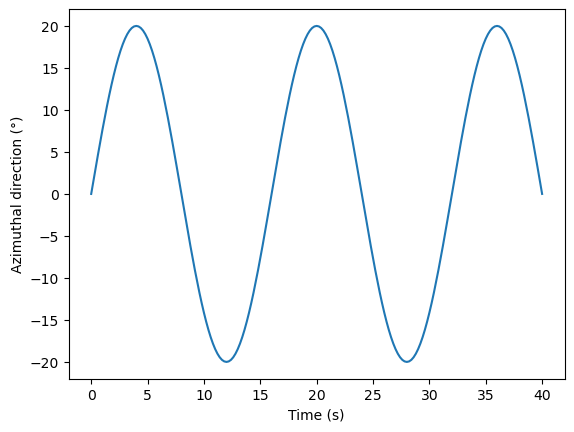

In [136]:
time_list = np.linspace(0, 40, 201)
azimuth_list = delta_az / 2 * np.sin(2*np.pi * f_scan * time_list)

plt.figure()
plt.plot(time_list, np.degrees(azimuth_list))
plt.xlabel('Time (s)')
plt.ylabel('Azimuthal direction (°)')
plt.show()
#plt.savefig('scanning_strategy.pdf')
#plt.close()

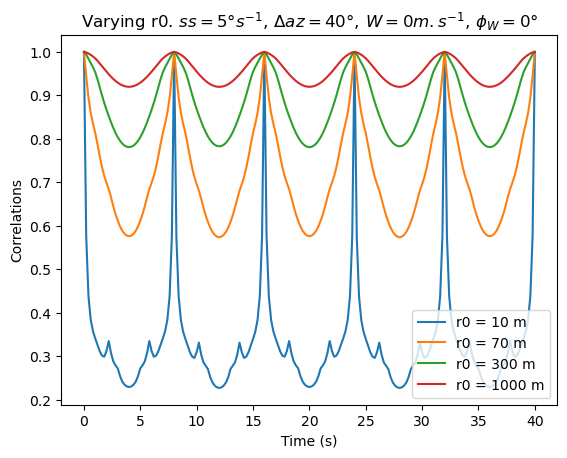

In [139]:
r0_list = [10, 70, 300, 1000]
plt.figure()

for r0 in r0_list:
    points = monte_carlo_points(freq, 9, r0=r0)
    
    corr = []
    for t in range(len(time_list)):
        time = time_list[t]
        azimuth = azimuth_list[t]
        corr.append(atm_correlations_qubic(points, list_peaks, list_peaks, ti=0, az_ti=azimuth_list[0], 
                                           el_ti=np.radians(45), tj=time, az_tj=azimuth, 
                                           el_tj=np.radians(45), W=W, phi_W=phi_W, freq=freq, r0=r0))
    plt.plot(time_list, corr/corr[0], label='r0 = '+str(r0)+' m')

r0 = 300

plt.xlabel('Time (s)')
plt.ylabel('Correlations')
plt.title('Varying r0. '+r'$ss = 5°s^{-1},\, \Delta az = 40°,\, W = 0 m.s^{-1},\, \phi_W = 0°$')
plt.legend(loc='lower right')
plt.show()
#plt.savefig('scanning_r0.pdf')
#plt.close()

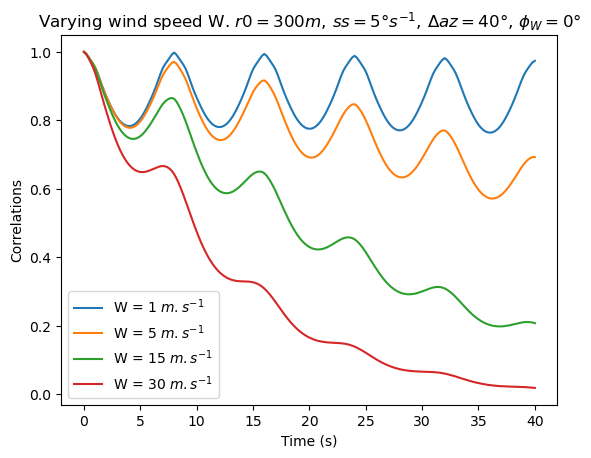

In [141]:
W_list = [1, 5, 15, 30]
plt.figure()

for Wind in W_list:
    points = monte_carlo_points(freq, 9, r0=r0)
    corr = []
    for t in range(len(time_list)):
        time = time_list[t]
        azimuth = azimuth_list[t]
        corr.append(atm_correlations_qubic(points, list_peaks, list_peaks, ti=0, az_ti=azimuth_list[0], 
                                           el_ti=np.radians(45), tj=time, az_tj=azimuth, 
                                           el_tj=np.radians(45), W=Wind, phi_W=phi_W, freq=freq, r0=r0))
    plt.plot(time_list, corr/corr[0], label='W = '+str(Wind)+r' $m.s^{-1}$')

plt.xlabel('Time (s)')
plt.ylabel('Correlations')
plt.title('Varying wind speed W. '+r'$r0 = 300 m,\, ss = 5°s^{-1},\, \Delta az = 40°,\, \phi_W = 0°$')
plt.legend()
plt.show()
#plt.savefig('scanning_wind.pdf')
#plt.close()

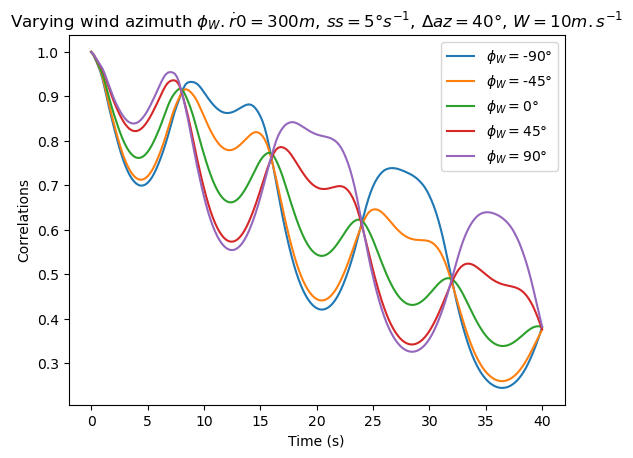

In [144]:
phi_W_list = [-90, -45, 0, 45, 90]
plt.figure()

for phi_Wind in phi_W_list:
    points = monte_carlo_points(freq, 9, r0=r0)
    corr = []
    for t in range(len(time_list)):
        time = time_list[t]
        azimuth = azimuth_list[t]
        corr.append(atm_correlations_qubic(points, list_peaks, list_peaks, ti=0, az_ti=azimuth_list[0], 
                                           el_ti=np.radians(45), tj=time, az_tj=azimuth, 
                                           el_tj=np.radians(45), W=10, phi_W=np.radians(phi_Wind), freq=freq, r0=r0))
    plt.plot(time_list, corr/corr[0], label=r'$\phi_W =$'+str(phi_Wind)+'°')

plt.xlabel('Time (s)')
plt.ylabel('Correlations')
plt.title('Varying wind azimuth '+r'$\phi_W.\. r0 = 300 m,\, ss = 5°s^{-1},\, \Delta az = 40°,\, W = 10 m.s^{-1}$')
plt.legend()
plt.show()
#plt.savefig('scanning_phi_W.pdf')
#plt.close()

## Decorelation effect due to the wind

In [160]:
W = 5                        # Speed of the wind (m s^-1)
phi_W = 0                    # Azimuth of the wind (rad)
freq = 150e9
r0 = 300
list_peaks = qubic_beam(231, freq)
nside = 16

In [161]:
pixel_disk = hp.query_disc(nside, hp.ang2vec(0, 0), np.radians(90))
npixel = len(pixel_disk)
theta, azimuth_list = hp.pixelfunc.pix2ang(nside=nside, ipix=pixel_disk)
elevation_list = np.pi/2 - theta

In [147]:
phi_W = 0
points = monte_carlo_points(freq, 9, r0=r0)
time_list = [0, 10, 20, 50, 80, 150] # sec

corr_list = []
for time in time_list:
    corr=[]
    for i in range(npixel):
        corr.append(atm_correlations_qubic(points, list_peaks, list_peaks, ti=0, az_ti=np.radians(0), 
                                               el_ti=np.radians(90), tj=time, az_tj=azimuth_list[i], 
                                               el_tj=elevation_list[i], W=W, phi_W=np.radians(phi_W), freq=freq, r0=r0))
    normalization = atm_correlations_qubic(points, list_peaks, list_peaks, ti=0, az_ti=np.radians(0), 
                                               el_ti=np.radians(90), tj=0, az_tj=np.radians(0), 
                                               el_tj=np.radians(90), W=0, phi_W=np.radians(phi_W), freq=freq, r0=r0)
    corr /= normalization
    corr_list.append(corr.copy())

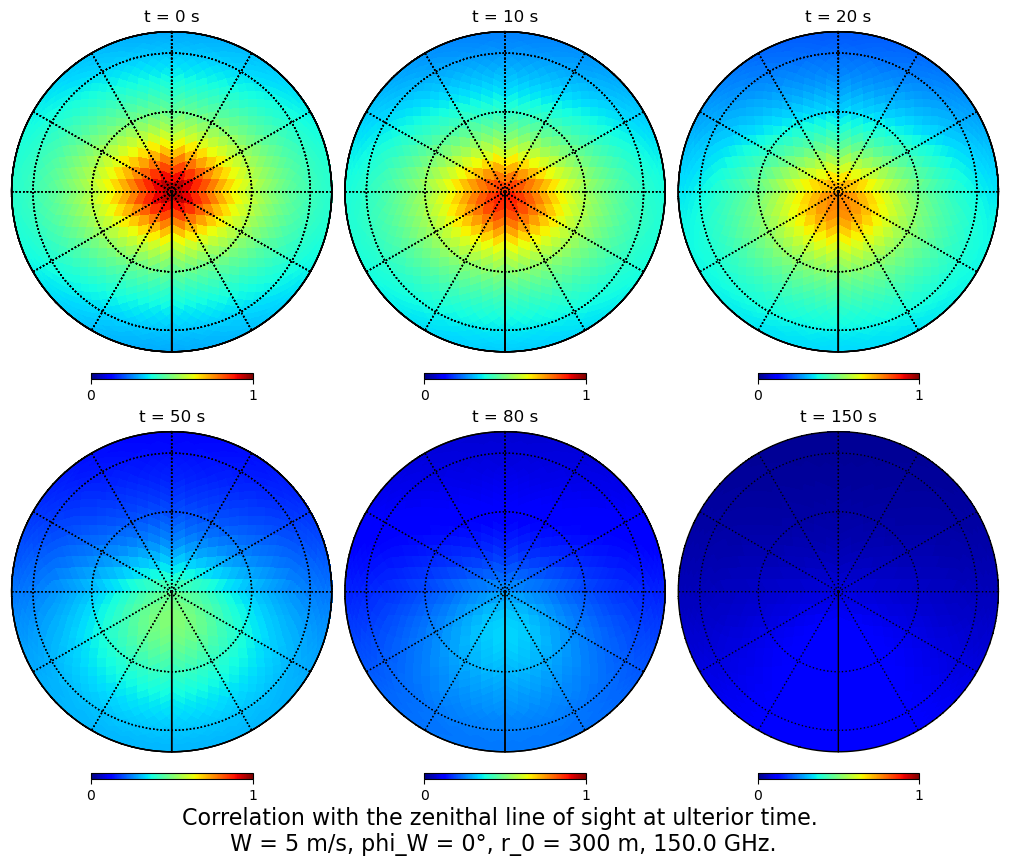

In [148]:
fig = plt.figure(figsize=(10, 8))
for index, corr in enumerate(corr_list):
    map = np.zeros(12*nside**2)
    map[pixel_disk] = corr
    hp.orthview(map, rot=(0,90,0), cmap='jet', min=0, max=1, half_sky=True, title=f't = {time_list[index]} s', sub=(2,3,index+1))
    hp.graticule(dpar=30, dmer=30)
fig.text(0.5, -0.05, f'Correlation with the zenithal line of sight at ulterior time.\n W = {W} m/s, phi_W = {phi_W}°, r_0 = {r0} m, {freq*1e-9} GHz.', ha='center', fontsize=16)
plt.show()

In [162]:
phi_W = 180
points = monte_carlo_points(freq, 9, r0=r0)
time_list = [0, 15, 30, 50, 80, 120] # sec

corr_list = []
for time in time_list:
    corr=[]
    for i in range(npixel):
        corr.append(atm_correlations_qubic(points, list_peaks, list_peaks, ti=0, az_ti=np.radians(0), 
                                               el_ti=np.radians(50), tj=time, az_tj=azimuth_list[i], 
                                               el_tj=elevation_list[i], W=W, phi_W=np.radians(phi_W), freq=freq, r0=r0))
    normalization = atm_correlations_qubic(points, list_peaks, list_peaks, ti=0, az_ti=np.radians(0), 
                                               el_ti=np.radians(50), tj=0, az_tj=np.radians(0), 
                                               el_tj=np.radians(50), W=0, phi_W=np.radians(phi_W), freq=freq, r0=r0)
    corr /= normalization
    corr_list.append(corr.copy())

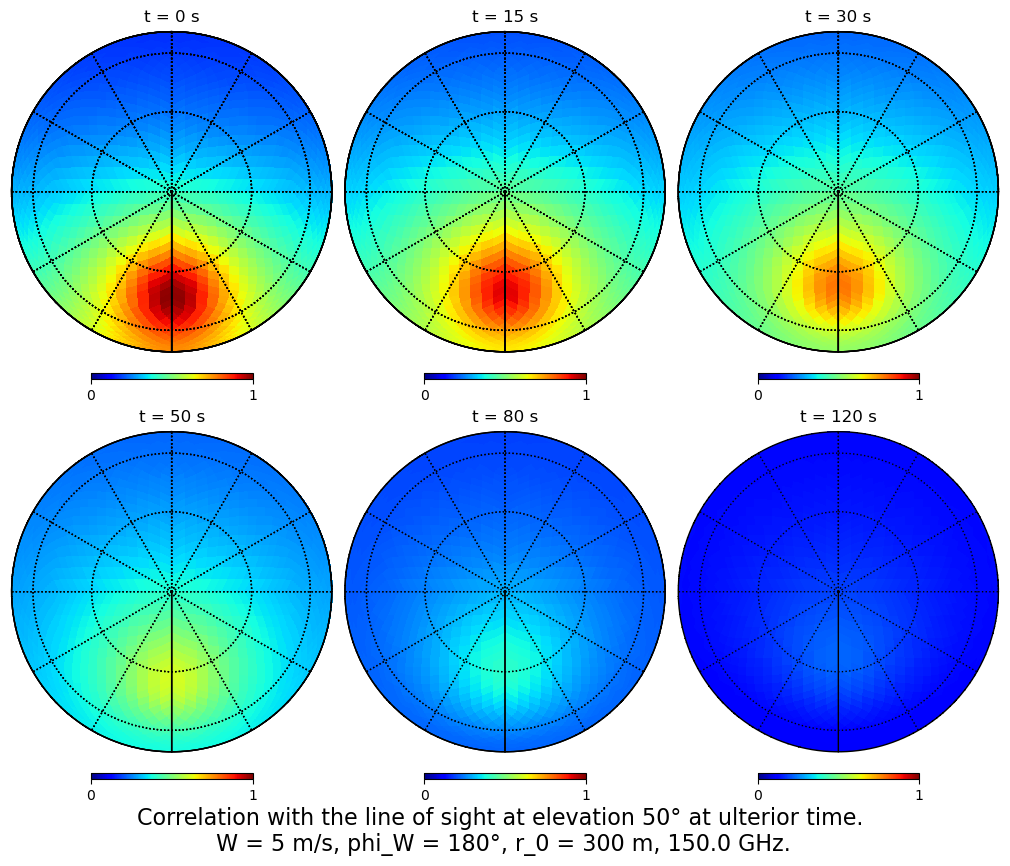

In [163]:
fig = plt.figure(figsize=(10, 8))
for index, corr in enumerate(corr_list):
    map = np.zeros(12*nside**2)
    map[pixel_disk] = corr
    hp.orthview(map, rot=(0,90,0), cmap='jet', half_sky=True, min=0, max=1, title=f't = {time_list[index]} s', sub=(2,3,index+1))
    hp.graticule(dpar=30, dmer=30)
fig.text(0.5, -0.05, f'Correlation with the line of sight at elevation 50° at ulterior time.\n W = {W} m/s, phi_W = {phi_W}°, r_0 = {r0} m, {freq*1e-9} GHz.', ha='center', fontsize=16)
plt.show()
#plt.savefig('decorrelation_parallax_top.pdf')
#plt.close()
            

In [164]:
phi_W = 90
points = monte_carlo_points(freq, 9, r0=r0)
time_list = [0, 15, 30, 50, 80, 120] # sec

corr_list = []
for time in time_list:
    corr=[]
    for i in range(npixel):
        corr.append(atm_correlations_qubic(points, list_peaks, list_peaks, ti=0, az_ti=np.radians(0), 
                                               el_ti=np.radians(50), tj=time, az_tj=azimuth_list[i], 
                                               el_tj=elevation_list[i], W=W, phi_W=np.radians(phi_W), freq=freq, r0=r0))
    normalization = atm_correlations_qubic(points, list_peaks, list_peaks, ti=0, az_ti=np.radians(0), 
                                               el_ti=np.radians(50), tj=0, az_tj=np.radians(0), 
                                               el_tj=np.radians(50), W=0, phi_W=np.radians(phi_W), freq=freq, r0=r0)
    corr /= normalization
    corr_list.append(corr.copy())

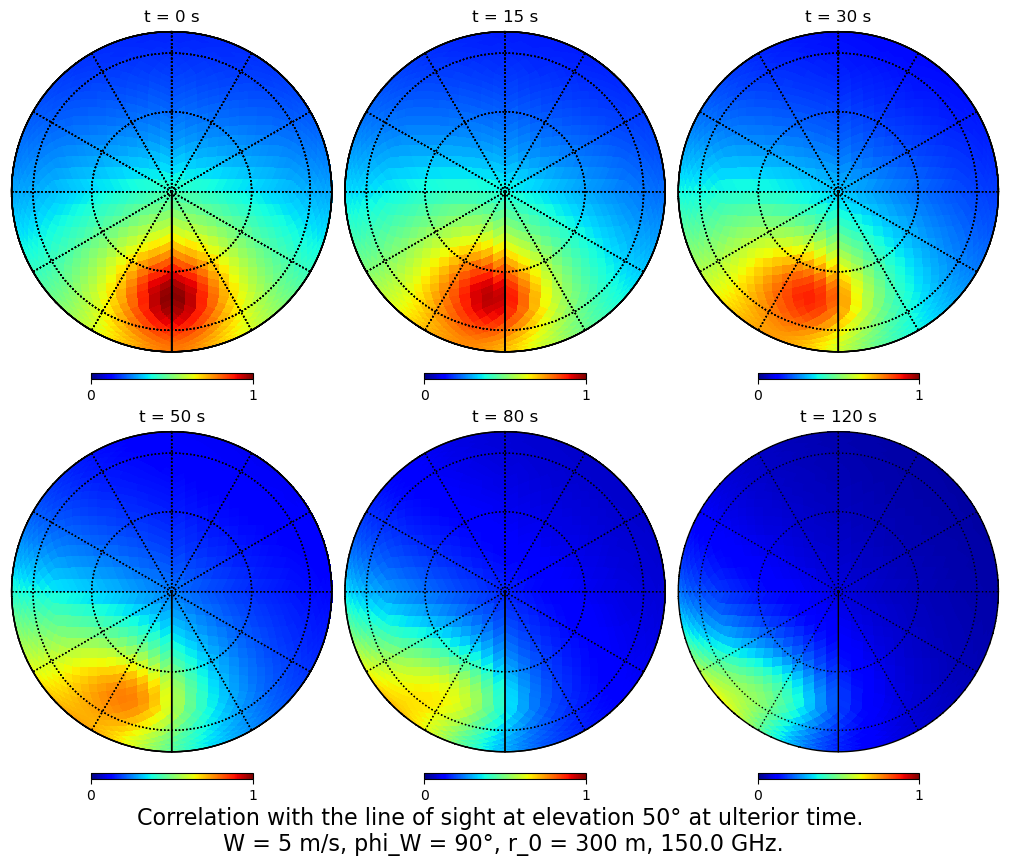

In [165]:
fig = plt.figure(figsize=(10, 8))
for index, corr in enumerate(corr_list):
    map = np.zeros(12*nside**2)
    map[pixel_disk] = corr
    hp.orthview(map, rot=(0,90,0), cmap='jet', half_sky=True, min=0, max=1, title=f't = {time_list[index]} s', sub=(2,3,index+1))
    hp.graticule(dpar=30, dmer=30)
fig.text(0.5, -0.05, f'Correlation with the line of sight at elevation 50° at ulterior time.\n W = {W} m/s, phi_W = {phi_W}°, r_0 = {r0} m, {freq*1e-9} GHz.', ha='center', fontsize=16)
plt.show()
#plt.savefig('decorrelation_parallax_left.pdf')
#plt.close()
